# Gaussian Hidden Markov Models

Gaussian Hidden Markov Models, `GHHMs`, are a type of HMMs where you have $Z$ states generating a sequence $X$ of values that are Gaussian distributed. $Z$ is said to be `hidden` since you never observe the state (at any particular time), and $X$ is said to be observed since you can see the sequence. The hidden states have a transition matrix $A$ that specifies the conditional probability of moving from the `i-th` state to the `j-th` state, denoted typically as, $a_{ij}$. The probability of an observation is Gaussian distributed with $\theta$ parameters. Typically, you may have prior knowledge of the initial state of the system, and this is represented by a probability vector $\pi$. A GHMM model, $\lambda$, is defined as follows.

$\lambda = (A, \theta, \pi)$

We are usually interested in solving three fundamental problems with a HMM (including GHHM). 

- `evaluation`: Given $X$ and $\lambda = (A, \theta, \pi)$, what is $P(X|\lambda)$?
- `recognition`: Given $X$ and $\lambda = (A, \theta, \pi)$, what is the best hidden state sequence $Z$ that best explains $X$?
- `training`: Given $X$, how do we learn the model parameters $\lambda = (A, \theta, \pi)$ to maximize $P(X|\lambda)$?

These problems are well understood and there are canonical algorithms to solve each.

- `evaluation`: Evaluation is solved by the [Foward-Backward algorithm](https://en.wikipedia.org/wiki/Forward%E2%80%93backward_algorithm).
- `recognition`: Recognition is solved by dynamic programming algorithms known as [Viterbi algorithm](https://en.wikipedia.org/wiki/Viterbi_algorithm).
- `training`: Training is solved by by the [Baum-Welch algorithm](https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm), a special instance of the [Expectation-Maximization (EM) algorithm](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm).

## Data

Let's sample data from a fictitious GHHM. 

- $A = \left[\begin{matrix}0.7 & 0.3 \\ 0.4 & 0.6\end{matrix}\right]$
- $\theta = [\mathcal N(1, 1), \mathcal N(5, 1)]$
- $\pi = [0.6, 0.4]$

We will trace the hidden states in $O_z$ and the observed values in $O_x$.

In [1]:
import numpy as np
from scipy.stats import norm
from random import choice
import bisect
import pandas as pd

np.random.seed(37)

p = np.array([0.6, 0.4])
Z = np.array([[0.7, 0.3], [0.4, 0.6]])
A = Z.cumsum(axis=1)
T = [norm(1, 1), norm(5, 1)]

O_z = []
O_x = []

n_iters = 100_000

z = bisect.bisect_left(p.cumsum(), np.random.random())
x = T[z].rvs()

for it in range(n_iters):
    O_z.append(z)
    O_x.append(x)

    z = bisect.bisect_left(A[z], np.random.random())
    x = T[z].rvs()

O_z = np.array(O_z)
O_x = np.array(O_x)

By tracing the sequence of hidden states in $O_z$, we can compute the marginal probabilties (also called the unconditional probabilities) of the states in $Z$.

In [2]:
s = pd.Series(O_z).value_counts().sort_index()
s / s.sum()

0    0.57421
1    0.42579
dtype: float64

Here's a snippet of the sequence of $Z$ in $O_z$.

In [3]:
O_z

array([1, 1, 1, ..., 0, 1, 1])

Here's a snippet of the sequence of $X$ in $O_x$.

In [4]:
O_x

array([ 3.62328106,  4.83910832,  4.3358552 , ..., -0.55832225,
        3.61938788,  4.89798618])

We can visualize the distribution of $O_x$. Clearly, the resulting density estimation of $X$ is a Gaussian mixture.

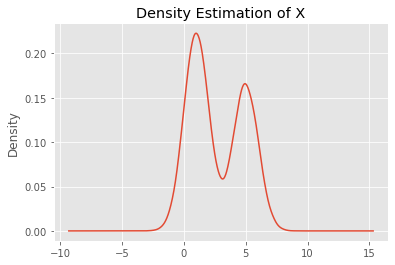

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')

_ = pd.Series(O_x).plot(kind='kde', title='Density Estimation of X')

## Training

We will use [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/index.html) to illustrate how to solve the three fundamental problems above. First, we will learn the model using the `fit()` function. The model is specified with `n_components=2` to represent the number of hidden states, but, typically, we do not how many hidden states there actually are. In this running example, we know the number of hidden states because we created the GHMM. 

In [6]:
from hmmlearn import hmm

Q = O_x.reshape(O_x.shape[0], 1)

model = hmm.GaussianHMM(n_components=2, n_iter=2_000).fit(Q)

mus = np.ravel(model.means_)
sigmas = np.ravel(np.sqrt([np.diag(c) for c in model.covars_]))
P = model.transmat_

This result shows the estimated $\theta$.

In [7]:
mus, sigmas

(array([1.00006561, 4.98655358]), array([1.00133963, 1.00569075]))

Here is the estimated $A$.

In [8]:
P

array([[0.70078564, 0.29921436],
       [0.40153297, 0.59846703]])

In general, the order of the elements in the estimated $\theta$ and $A$ will not correspond to the original ones. We simply got `lucky` here that the states/elements corresponded!

## Recognition

Recognition is solved using the `predict()` method, which predicts the sequence of hidden state in $Z$ from the sequence of observations in $X$.

In [9]:
hidden_states = model.predict(Q)

s = pd.Series(hidden_states).value_counts().sort_index()
s / s.sum()

0    0.57365
1    0.42635
dtype: float64

You can also use the `decode()` method too, which will return `(score, hidden state sequence)`.

In [10]:
_, hidden_states = model.decode(Q)

s = pd.Series(hidden_states).value_counts().sort_index()
s / s.sum()

0    0.57365
1    0.42635
dtype: float64

## Evaluation

The `score()` method will return the log probability of the observed sequence.

In [11]:
model.score(Q)

-200384.94195070988